In [ ]:
# Import relevant libraries

!pip install spotipy

     |████████████████████████████████| 63 kB 1.2 MB/s 
     |████████████████████████████████| 138 kB 25.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import pandas as pd
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from bs4 import BeautifulSoup
import requests

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from torchtext.legacy import data as torchtext_data

In [ ]:
# Connect to Spotify

cid ='5e9160c5b94c4811ab7c239b3a36a460'
secret ='f8288b7c62564f25a5c7d94bd185e896'

client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [ ]:
# Function to scrape lyrics from Genius

def get_album_tracks(uri_info, limit, offset=0):
  titles = []
  artists = []
  one = sp.playlist_tracks(uri_info, limit=limit, offset=offset, market='US')
  df1 = pd.DataFrame(one)
  for i, x in df1['items'].items():
    track = x['track']
    titles.append(track['name'])
    artists.append(track['artists'][0]['name'])
    df2 = pd.DataFrame({'title':titles,'artist':artists})
  return df2

def scrape_lyrics(artistname, songname):
  artistname2 = str(artistname.replace(' ','-')) if ' ' in artistname else str(artistname)
  songname2 = str(songname.replace(' ','-')) if ' ' in songname else str(songname)
  page = requests.get('https://genius.com/'+ artistname2 + '-' + songname2 + '-' + 'lyrics')
  html = BeautifulSoup(page.text, 'html.parser')

  lyrics1 = html.find("div", class_="lyrics")
  lyrics2 = html.find("div", class_="Lyrics__Container-sc-1ynbvzw-6 jYfhrf")
  if lyrics1:
    lyrics = lyrics1.get_text()
  elif lyrics2:
    lyrics = lyrics2.get_text()
  elif lyrics1 == lyrics2 == None:
    lyrics = None

  lines = []
  for div in html.findAll('div', {'class': 'Lyrics__Container-sc-1ynbvzw-6 jYfhrf'}):
    lines.extend([text if text[0] != '[' else ' ' for text in div.stripped_strings])
    
  lyrics = ""
  for line in lines:
    if line != ' ':
      lyrics += line + '@'  

  return lyrics


In [ ]:
# Scrape lyrics for the target genre

uri = 'spotify:playlist:5JDQq97ipoyekmMG5If3yc'
collections = [get_album_tracks(uri, 100, 0), 
               get_album_tracks(uri, 100, 100), 
               get_album_tracks(uri, 100, 200), 
               get_album_tracks(uri, 12, 300)]

lyrics = []
for df_tracks in collections:
  for index, row in df_tracks.iterrows():
      song = scrape_lyrics(row['artist'], row['title'])
      if song != '':
        lyrics.append([song])

print(lyrics[-1])

["She used to be@Everything to me@When she was my girl@When she was my girl@I held her near@Told her how much I cared@When she was my girl@When she was my girl@When she was my girl@There was laughter and loving in my world@Everyday@When she was my girl@Oh what joy she would bring@Now I've lost everything@She's gone, gone, gone, gone, gone@I spend the night@Dreaming how she used to be@When she was my girl@When she was my girl@When she was my girl@There was laughter and loving in my world@Yes It Was@Cause she was my girl@Oh what joy she would bring@Now I've lost everything@She's gone,  my big legged girl is gone@She used to be@Everything to me@When she was my girl@When she was my girl@She, she's my girl@She's so foxy can't you see@And this girl belongs to me@She's my girl@When we walk down the street@I would tell everyone we meet@This is my girl@She, she was my girl@I loved, I loved ...@"]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import csv 

f_lyrics = open('/content/drive/MyDrive/csv_lyrics', 'w')
writer = csv.writer(f_lyrics)

for l in lyrics:
  writer.writerow(l)  

f_lyrics.close()

In [ ]:
f_overfit = open('/content/drive/MyDrive/csv_lyrics_overfit', 'w')
writer = csv.writer(f_overfit)

writer.writerow([lyrics[1]])  

f_overfit.close()

In [ ]:
# Count characters

chars = set()
for song in lyrics:
  for line in song:
    temp = list(set(line))
    for char in temp:
      chars.add(char)

chars.add("<BOS>")
chars.add("<EOS>")
chars = sorted(chars)
char_size = len(chars)

print(chars)
print("Number of unique characters: " + str(char_size))

[' ', '!', '"', "'", '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<BOS>', '<EOS>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '}', 'ñ', '\u2005', '—', '‘', '’', '…']
Number of unique characters: 84


In [ ]:
# Create dictionary of characters

char_to_index = dict((c, i) for i, c in enumerate(chars))
index_to_char = dict((i, c) for i, c in enumerate(chars))

print(char_to_index)
print(index_to_char)

{' ': 0, '!': 1, '"': 2, "'": 3, '(': 4, ')': 5, ',': 6, '-': 7, '.': 8, '0': 9, '1': 10, '2': 11, '3': 12, '4': 13, '5': 14, '6': 15, '7': 16, '8': 17, '9': 18, ':': 19, ';': 20, '<BOS>': 21, '<EOS>': 22, '?': 23, '@': 24, 'A': 25, 'B': 26, 'C': 27, 'D': 28, 'E': 29, 'F': 30, 'G': 31, 'H': 32, 'I': 33, 'J': 34, 'K': 35, 'L': 36, 'M': 37, 'N': 38, 'O': 39, 'P': 40, 'Q': 41, 'R': 42, 'S': 43, 'T': 44, 'U': 45, 'V': 46, 'W': 47, 'Y': 48, ']': 49, 'a': 50, 'b': 51, 'c': 52, 'd': 53, 'e': 54, 'f': 55, 'g': 56, 'h': 57, 'i': 58, 'j': 59, 'k': 60, 'l': 61, 'm': 62, 'n': 63, 'o': 64, 'p': 65, 'q': 66, 'r': 67, 's': 68, 't': 69, 'u': 70, 'v': 71, 'w': 72, 'x': 73, 'y': 74, 'z': 75, '{': 76, '}': 77, 'ñ': 78, '\u2005': 79, '—': 80, '‘': 81, '’': 82, '…': 83}
{0: ' ', 1: '!', 2: '"', 3: "'", 4: '(', 5: ')', 6: ',', 7: '-', 8: '.', 9: '0', 10: '1', 11: '2', 12: '3', 13: '4', 14: '5', 15: '6', 16: '7', 17: '8', 18: '9', 19: ':', 20: ';', 21: '<BOS>', 22: '<EOS>', 23: '?', 24: '@', 25: 'A', 26: 'B'

In [ ]:
# Building the model

class SongGeneratorGRU(nn.Module):
  def __init__(self, char_size, embedding_size, hidden_size):
    super(SongGeneratorGRU, self).__init__()

    # Embedding layer
    self.embed = nn.Embedding(num_embeddings=char_size, embedding_dim=embedding_size)

    # RNN layer
    self.rnn = nn.GRU(input_size=embedding_size, hidden_size=hidden_size, batch_first=True)

    # Projection MLP layer
    self.mlp = nn.Linear(in_features=hidden_size, out_features=char_size)

  def forward(self, data, hidden=None):
    emb = self.embed(data)
    output, hidden = self.rnn(emb, hidden)
    output = self.mlp(output)
    return output, hidden


In [ ]:
 # Train with Teacher Forcing

def train(model, data, vocab_size, batch_size=1, num_epochs=1, lr=0.001, print_every=100):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    it = 0
    
    losses, train_acc, valid_acc = [], [], []
    epochs = []

    data_iter = torchtext_data.BucketIterator(data, 
                                              batch_size=batch_size,
                                              sort_key=lambda x: len(x.text),
                                              sort_within_batch=True)
    
    for e in range(num_epochs):
        # get training set
        avg_loss = 0
        for (lyric, lengths), label in data_iter:
            target = lyric[:,1:]
            inp = lyric[:,:-1]
            # cleanup
            optimizer.zero_grad()
            # forward pass
            output, hidden = model(inp)
            loss = criterion(output.reshape(-1, vocab_size), target.reshape(-1))
            # backward pass
            loss.backward()
            optimizer.step()

            avg_loss += loss
            losses.append(float(loss)/lyric.size()[0])
            it += 1 # increment iteration count
            if it % print_every == 0:
                print("[Iter %d] Loss %f" % (it+1, float(avg_loss/print_every)))
                avg_loss = 0
        
        

    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

47
[Iter 11] Loss 0.152794
[Iter 21] Loss 0.073425
[Iter 31] Loss 0.028791
[Iter 41] Loss 0.010719
[Iter 51] Loss 0.004770
[Iter 61] Loss 0.002826


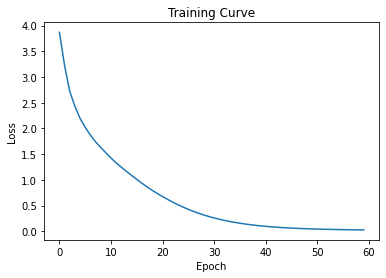

In [ ]:
text_field_overfit = torchtext_data.Field(sequential=True,      # text sequence
                                  tokenize=lambda x: x, # because are building a character-RNN
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True,       # to turn each character into an integer index
                                  init_token="<BOS>",   # BOS token
                                  eos_token="<EOS>")    # EOS token

fields_overfit = [('text', text_field_overfit)]
lyrics_overfit = torchtext_data.TabularDataset("/content/drive/MyDrive/csv_lyrics_overfit", "csv", fields_overfit)
text_field_overfit.build_vocab(lyrics_overfit)
vocab_stoi_overfit = text_field_overfit.vocab.stoi # so we don't have to rewrite sample_sequence
vocab_itos_overfit = text_field_overfit.vocab.itos # so we don't have to rewrite sample_sequence
vocab_size_overfit = len(text_field_overfit.vocab.itos)
print(vocab_size_overfit)
len(lyrics_overfit)

model = SongGeneratorGRU(vocab_size_overfit, 256, 256) #char_size, embedding_size, hidden_size
train(model, lyrics_overfit, vocab_size_overfit, batch_size=1, num_epochs=60, lr=0.004, print_every=10)

In [ ]:
text_field = torchtext_data.Field(sequential=True,      # text sequence
                                  tokenize=lambda x: x, # because are building a character-RNN
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True,       # to turn each character into an integer index
                                  init_token="<BOS>",   # BOS token
                                  eos_token="<EOS>")    # EOS token

fields = [('text', text_field)]
lyrics = torchtext_data.TabularDataset("/content/drive/MyDrive/csv_lyrics", "csv", fields)
text_field.build_vocab(lyrics)
vocab_stoi = text_field.vocab.stoi # so we don't have to rewrite sample_sequence
vocab_itos = text_field.vocab.itos # so we don't have to rewrite sample_sequence
vocab_size = len(text_field.vocab.itos)
print(vocab_size)
len(lyrics)

86


176

[Iter 51] Loss 0.455567
[Iter 101] Loss 0.274778
[Iter 151] Loss 0.149856
[Iter 201] Loss 0.045038
[Iter 251] Loss 0.362286
[Iter 301] Loss 0.257558
[Iter 351] Loss 0.163556
[Iter 401] Loss 0.078083
[Iter 451] Loss 0.343373
[Iter 501] Loss 0.252763
[Iter 551] Loss 0.172609
[Iter 601] Loss 0.101485
[Iter 651] Loss 0.031363
[Iter 701] Loss 0.260477
[Iter 751] Loss 0.186800
[Iter 801] Loss 0.116712
[Iter 851] Loss 0.063098
[Iter 901] Loss 0.273792
[Iter 951] Loss 0.209787
[Iter 1001] Loss 0.155668
[Iter 1051] Loss 0.083389
[Iter 1101] Loss 0.027014
[Iter 1151] Loss 0.231781
[Iter 1201] Loss 0.176259
[Iter 1251] Loss 0.115295
[Iter 1301] Loss 0.060522
[Iter 1351] Loss 0.270431
[Iter 1401] Loss 0.203327
[Iter 1451] Loss 0.149816
[Iter 1501] Loss 0.091177
[Iter 1551] Loss 0.028731
[Iter 1601] Loss 0.255124
[Iter 1651] Loss 0.197414
[Iter 1701] Loss 0.132240


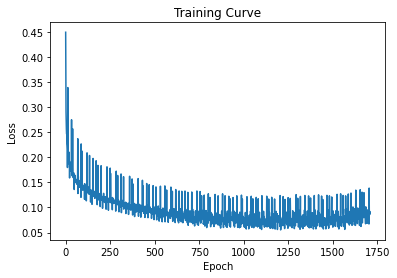

In [ ]:
model = SongGeneratorGRU(vocab_size, 256, 256) #char_size, embedding_size, hidden_size
train(model, lyrics, vocab_size, batch_size=10, num_epochs=95, lr=0.007, print_every=50)

In [ ]:
# LET'S MAKE SOME MUSIC 🎵🎶

def sample_sequence(model, max_len=100, temperature=0.8):
    generated_sequence = ""
   
    inp = torch.Tensor([vocab_stoi["<BOS>"]]).long()
    hidden = None
    for p in range(max_len):
        output, hidden = model(inp.unsqueeze(0), hidden)
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = int(torch.multinomial(output_dist, 1)[0])
        # Add predicted character to string and use as next input
        predicted_char = vocab_itos[top_i]
        
        if predicted_char == "<EOS>":
            break
        generated_sequence += predicted_char       
        inp = torch.Tensor([top_i]).long()
    return generated_sequence.replace('@', '\n')

In [ ]:
print(sample_sequence(model, max_len=1500, temperature=0.5))

When I things of love's always been good to go
Through the wings of love
No ordinary love, sweet love, digital love
Not that special talking there's not easy
I'm saving allways
Will it's not to do
Why sweet shine
I sing my heart tonight, oh, oh, oh, baby
If you're the end, girl, I'm near
And I'm so glad you could know what I wanna love
Oh, baby, it's true
(No, baby, just)
Sweet sweet love
Oh, baby, just to know, it's true
Turne when I thought it overy limitales home
But what it seems to have in my heart
'Cause you said I'd never knew you were and stay
I stand the rain?
Can you stand the rain?
(
Se's gonna be alright)
If you are the rain?
Said it asking for you
Show me to me
(Oh, when you wanna love, wanna love you, baby)
It's waitin' for you
That's what I need you
(
I'm lost in love
) I can't live without you
(
I'm lost in love
) Chous and mean sometimes
Said boy dreaming
He laught I'd never knew
I know that I need
One day the sky for answer
This is no starting alone
Together for the s